---
title: Linear Convection
---

In [11]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} + c \frac{\partial u}{\partial y} = 0
```


For this, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right) - c \frac{\Delta t}{\Delta y}\left( u_{i,j}-u_{i,j-1}^n \right)
```

In [12]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# defime some variables
nx = 81
ny = 81
nt = 100
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)

sigma = .2
dt = sigma * dx

In [14]:
# initialize field to be zero
u = 2* jnp.ones((nx, ny))

In [15]:
u.shape

(81, 81)

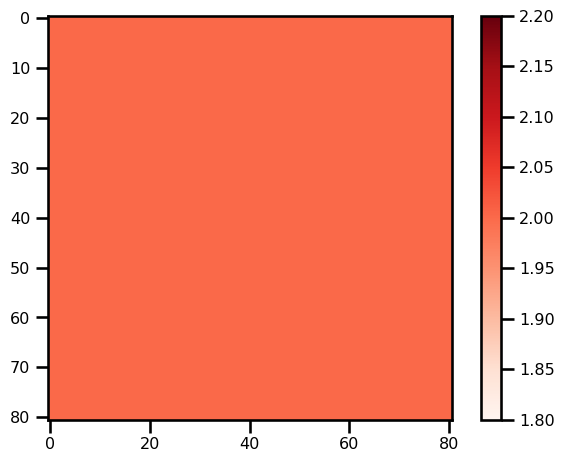

In [16]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

In [17]:
# initialize field to be constant
u = 2* np.ones((nx, ny))

for t in trange(nt + 1):
    
    # copy to avoid overwriting
    un = u.copy()
    
    # apply boundary conditions
    u[0, :] = 1. # left
    u[-1, :] = 1. # right
    u[:, 0] = 1. # bottom
    u[:, -1] = 1. # top
    
    # calculate the terms
    t1 = un[1:, 1:]
    t2 = - c * (dt / dy) * (un[1:, 1:] - un[1:, :-1])
    t3 = - c * (dt / dx) * (un[1:, 1:] - un[:-1, 1:])
    
    u[1:, 1:] =  t1 + t2 + t3
    

# small sanity check
assert (u[45:55, 45:55] > 1.8).all()

  0%|          | 0/101 [00:00<?, ?it/s]

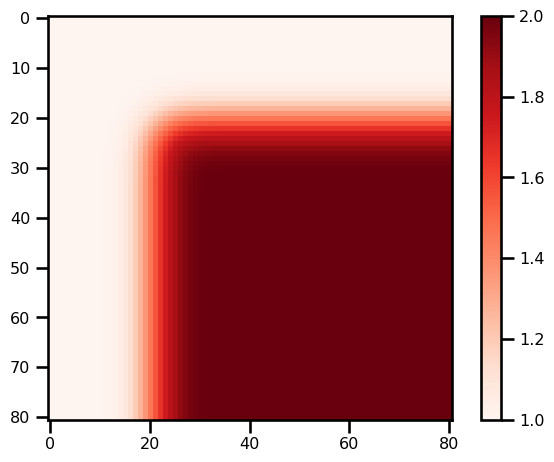

In [18]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Jax Syntax

**Problems**:

* Add the jax syntax
* Add the inplace changes

In [19]:
# initialize field to be constant
u = 2* jnp.ones((nx, ny))

for t in trange(nt + 1):
    
    # copy to avoid overwriting
    un = u.copy()
    
    # apply boundary conditions
    u = u.at[0, :].set(1.) # left
    u = u.at[-1, :].set(1.) # right
    u = u.at[:, 0].set(1.) # bottom
    u = u.at[:, -1].set(1.) # top
    
    # calculate the terms
    t1 = un[1:, 1:]
    t2 = - c * (dt / dy) * (un[1:, 1:] - un[1:, :-1])
    t3 = - c * (dt / dx) * (un[1:, 1:] - un[:-1, 1:])
    
    u = u.at[1:, 1:].set(t1 + t2 + t3)
    

# small sanity check
assert (u[45:55, 45:55] > 1.8).all()

  0%|          | 0/101 [00:00<?, ?it/s]

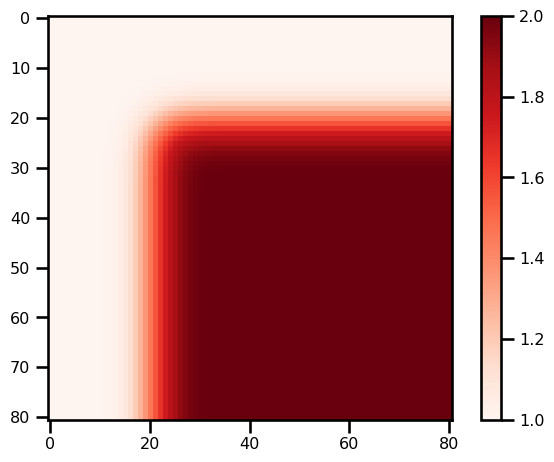

In [20]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

## Refactor!

So right away, we are going to start to refactor our solver to be more generalized. Below, I have outlined a few things that could possibly be refactored "easily".

* Objects (domain, field)
* Operators (derivatives)
* Boundary Conditions
* Time stepper! 

## Domain


```{math}
:label: domain
\mathbf{x}\in\Omega\sub\mathbb{R}^{D_s} \hspace{10mm}
```

Practically speaking, this is a vector. However, we never actually have to store the vector; just the boundaries and the discretization.

In [20]:
# from jaxsw._src.domain.base import Domain
from jaxdf.geometry import Domain


In [21]:
# defime some variables
nx = 81
ny = 81
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)

# initialize domain class
domain = Domain(N=(nx, ny), dx=(dx, dy))

# some checks!
assert domain.ndim == 2
assert len(domain.size) == domain.ndim
assert len(domain.spatial_axis) == 2
assert domain.grid.shape == (nx, ny, domain.ndim)

## Field

```{math}
:label: field
u = \boldsymbol{u}(\mathbf{x}) \hspace{10mm} \boldsymbol{u}: \Omega\rightarrow\mathbb{R}^{D_u}\hspace{5mm} \mathbf{x}\in\Omega
```

In [27]:
from jaxdf.discretization import FiniteDifferences

# define input
init_u = 2* jnp.ones((nx, ny))
u = FiniteDifferences.from_grid(grid_values=init_u, domain=domain)
u

FiniteDifferences[dims=1, size=(81, 81)]

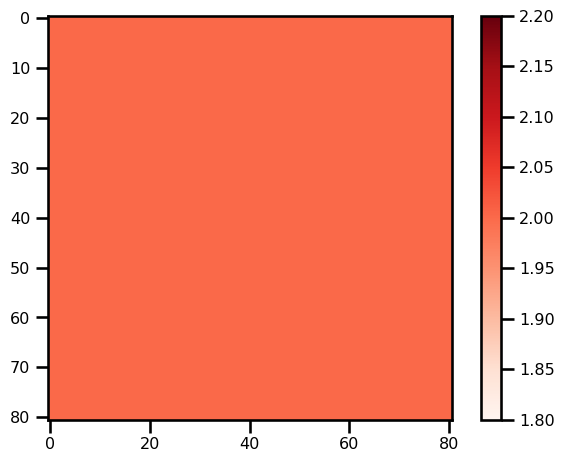

In [28]:
fig, ax = plt.subplots()
pts = ax.imshow(u.params, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

So a field is a new object that has a set of operations. For example we can add, multiply, subtract and divide by other fields. We can also do a negative value and powers. Because of the custom definition of `field`, it is designed to only do the operations on the internal values, i.e. `field.values`.

In [43]:
# addition
u2 = u + u

np.testing.assert_equal(u2.params.min().item(), 4.)
np.testing.assert_equal(u2.params.max().item(), 4.)

# power
u2 = u ** 3

np.testing.assert_equal(u2.params.min().item(), 8.)
np.testing.assert_equal(u2.params.max().item(), 8.)

In [36]:
u2.params.min()

Array(4., dtype=float32)

## Operators

Now, we want to use some of the differential operators available. In the above example, we immediately chose the spatial and temporal discretization to give us a bit of a nasty PDE. Using this package, we want to look at the two discretizations separately. In fact, we will only be paying attention to the spatial discretization using the `operators` available in this package.

So let's rewrite the PDE only looking at the spatial discretization.

$$
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right) - c \frac{1}{\Delta y}\left( u_{i,j}-u_{i,j-1}^n \right)
$$